In [1]:
%%bash
# Extract raw data
tar -zxf ../raw_data/20190808.tar.gz -C ../raw_data

In [2]:
%matplotlib inline

# Import packages
import pandas as pd
import datetime as dt
import os

# Import user-defined module with regression and plotting functions
from src.calibrate import *

meas_day = "20190808"
data_directory = "../raw_data/"+meas_day+"/"

# Reformat measurement day to the format that GC uses
dt_day = dt.datetime.strptime(meas_day, "%Y%m%d")
gc_day = dt_day.strftime("%-m%d%Y")

infiles = os.listdir(data_directory)

# First create a pandas dataframe of peak table info from the GC 
# ascii files created during each individual sample run 
df = pd.DataFrame(columns=["sample", "N2O_peak", "CO2_peak", "CH4_peak"])

for file in infiles:
    sample = file # sample name
    peaks = get_peak_info(data_directory+file, CH4_check=0) # tuple of 3 peak areas
    
    df = df.append({"sample": sample, "N2O_peak": peaks[0], 
                                      "CO2_peak": peaks[1], 
                                      "CH4_peak": peaks[2]}, ignore_index=True)
# pd.set_option('display.max_rows', 106)
# print(df)

In [3]:
# Create new dataframe with location, date, depth and vial number info
samples = sample_info_from_filename(df, 'sample')

# Drop the filename with incomplete information (Gas_PTC1-_20190610-H, Gas_PTC1-_20190610-H)
samples.drop([30, 31], axis=0, inplace=True)

# pd.set_option('display.max_rows', 90)
# print(samples)

In [4]:
# Get info from standards
stds = df[df['sample'].str.contains('Std')].copy()

QCfilter = stds['sample'].str.match('QC') # Drop rows that are QC
QC = stds[QCfilter]
stds = stds[~QCfilter]

# Get the std concentration from the sample name
stds['ppm'] = stds['sample'].str.extract(r'Std_(\d+)ppm')
stds['ppm'] = pd.to_numeric(stds['ppm']) # Convert to float

# Correct for N2O Std concentrations less than 1
i = stds.index[stds['sample'].str.match('N2OStd_05')]
stds.loc[i, ['ppm']] = 0.5
i = stds.index[stds['sample'].str.match('N2OStd_0101')]
stds.loc[i, ['ppm']] = 0.101

# Convert peaks to numeric
stds['N2O_peak'] = pd.to_numeric(stds['N2O_peak'])
stds['CO2_peak'] = pd.to_numeric(stds['CO2_peak'])
stds['CH4_peak'] = pd.to_numeric(stds['CH4_peak'])

print(stds)
print(QC)

                           sample  N2O_peak  CO2_peak  CH4_peak        ppm
0     CH4Std_100ppm_882019_13.txt     60749    987863     45525    100.000
1      CH4Std_10ppm_882019_12.txt     50276   1917270     23326     10.000
2       CH4Std_2ppm_882019_11.txt     49819    191774    147754      2.000
3    CH4Std_5030ppm_882019_14.txt     47324    374270  10285419   5030.000
4    CO2Std_10100ppm_882019_4.txt     44697  16342873         0  10100.000
5     CO2Std_1010ppm_882019_3.txt     48561   2019450         0   1010.000
6    CO2Std_50000ppm_882019_5.txt     54485  49034036      2642  50000.000
7      CO2Std_500ppm_882019_2.txt     17054   1083680         0    500.000
8               CO2Std_605ppm.txt    173120   1206861     13577    605.000
98   N2OStd_0101ppm_882019_25.txt     45595    371331      2893      0.101
99     N2OStd_05ppm_882019_26.txt     93793    229546      2967      0.500
100    N2OStd_10ppm_882019_28.txt    920312    447699      2606     10.000
101     N2OStd_1ppm_88201

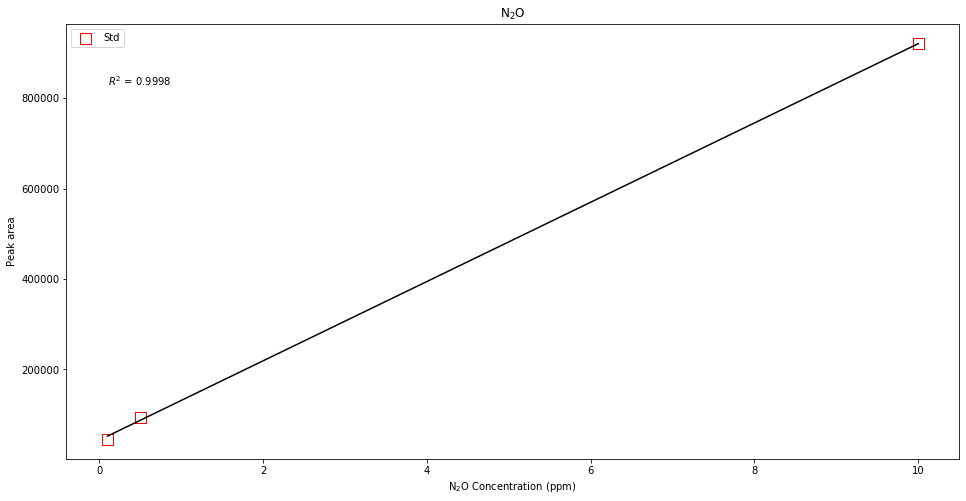

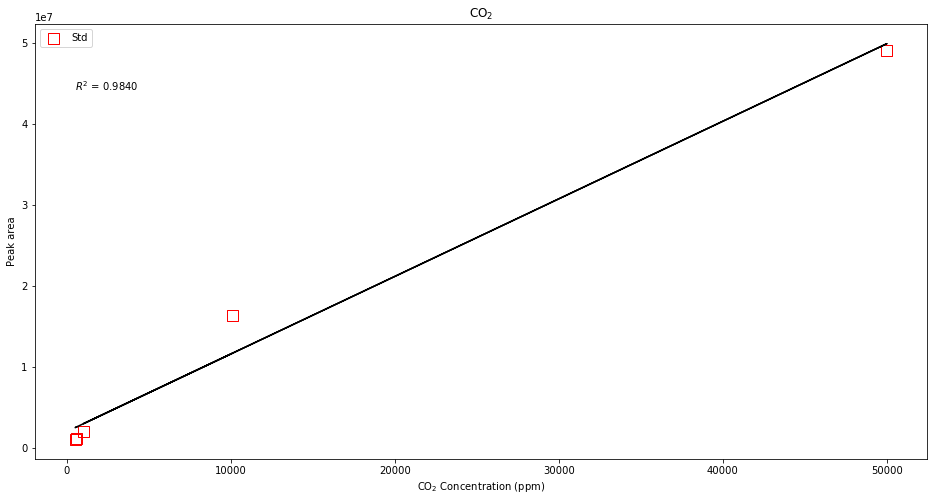

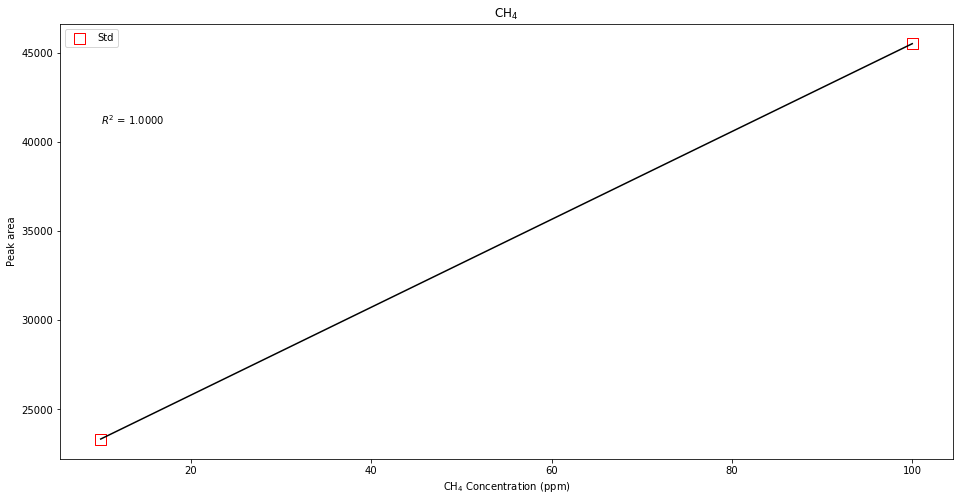

In [5]:
# Separate out N2O, CH4 and CO2 standards
N2Ostd  = stds[stds['sample'].str.contains("N2OStd")].copy()
CO2std  = stds[stds['sample'].str.contains("CO2Std")].copy()
CH4std  = stds[stds['sample'].str.contains("CH4Std")].copy()

# Play around with CH4 standard curve
CH4std = CH4std[~CH4std['sample'].str.contains('5030ppm')] # Drop 5000 ppm since no samples are above 10 ppm
CH4std = CH4std[~CH4std['sample'].str.contains('_2ppm')] # 2ppm looks absurdly high

# Play around with N2O standard curve 
N2Ostd = N2Ostd[~N2Ostd['sample'].str.contains('_80ppm')] # Drop 80 ppm since no samples are above 10 ppm
N2Ostd = N2Ostd[~N2Ostd['sample'].str.contains('_1ppm')] # Drop 1 ppm as well -- based on previous days, it may be high

# Play around with CO2 standard curve
# CO2std = CO2std[~CO2std['sample'].str.contains('_10100ppm')] # 10100 ppm looks high as well
# CO2std = CO2std[~CO2std['sample'].str.contains('_50000ppm')] # Or is 50000 low?

# Plot the standards with linear regression trendline
plot_standards(N2Ostd['ppm'],N2Ostd['N2O_peak'],r'N$_2$O')
plot_standards(CO2std['ppm'],CO2std['CO2_peak'],r'CO$_2$')
plot_standards(CH4std['ppm'],CH4std['CH4_peak'],r'CH$_4$')

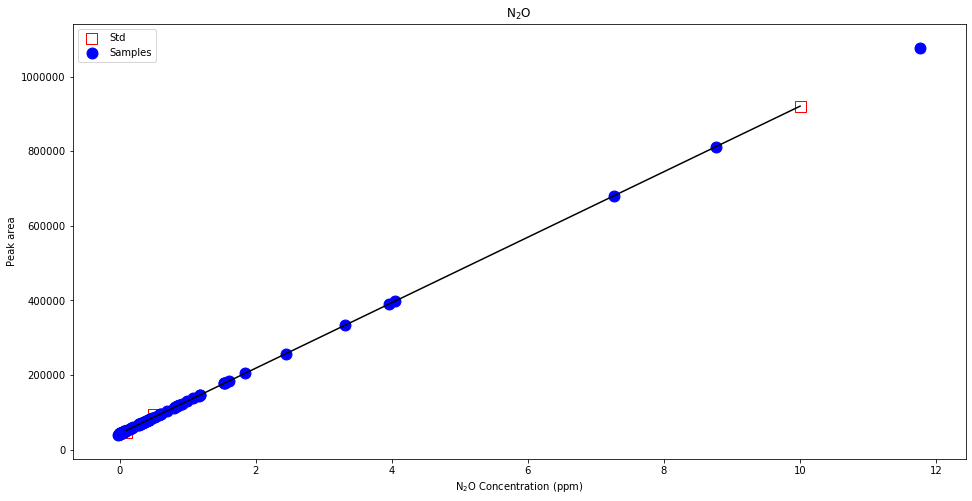

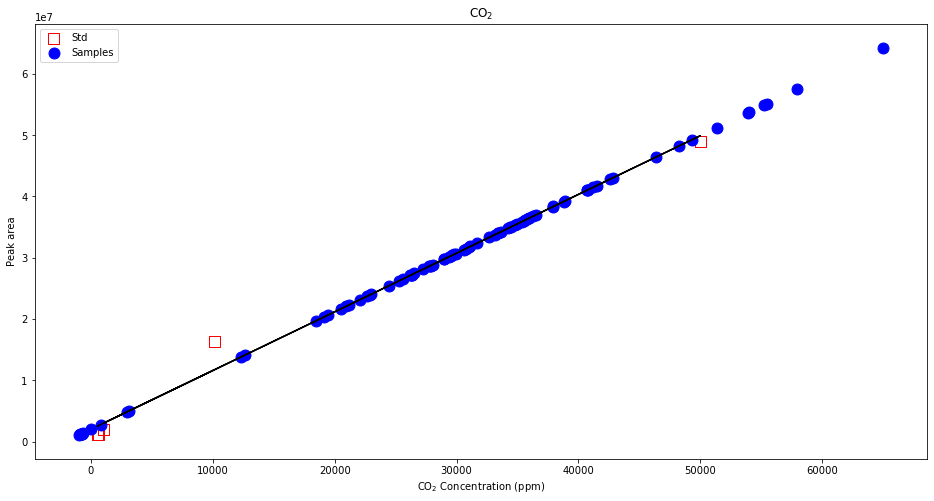

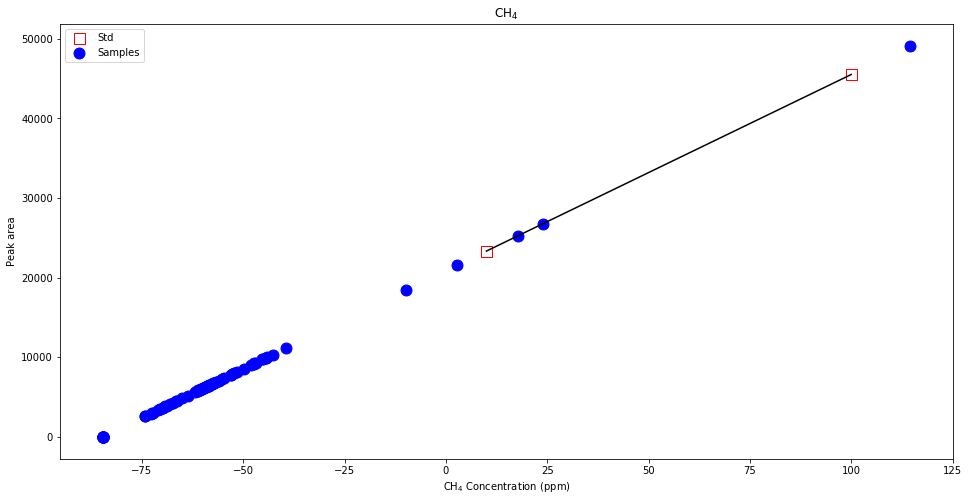

In [6]:
# Now, plot the standards along with the samples
plot_samples(samples['N2O_peak'], N2Ostd['ppm'], N2Ostd['N2O_peak'], r"N$_2$O")
plot_samples(samples['CO2_peak'], CO2std['ppm'], CO2std['CO2_peak'], r"CO$_2$")
plot_samples(samples['CH4_peak'], CH4std['ppm'], CH4std['CH4_peak'], "CH$_4$")

In [7]:
# Since the data look good, export the sample concentrations to a text file
saveoutput = save_sampleconc_new(N2Ostd['ppm'], N2Ostd['N2O_peak'], 
                                 CO2std['ppm'], CO2std['CO2_peak'], 
                                 CH4std['ppm'], CH4std['CH4_peak'], 
                                 samples, "../processed_data/RVT_TracerTest_GasConcentrations_20190808.txt", 
                                 write_to_datafile=True)

print(saveoutput)

   vial location depth       date method    dup  N2O_conc  N2O_bdl  \
9    98     NTC1   110 2019-07-15      H  False  1.538873    False   
10   99     NTC1   140 2019-07-15      H  False  0.050500     True   
11   95     NTC1    20 2019-07-15      H  False  0.420237    False   
12   96     NTC1    50 2019-07-15      H  False  0.609743    False   
13   97     NTC1    80 2019-07-15      H  False  1.544355    False   
..  ...      ...   ...        ...    ...    ...       ...      ...   
93   68     PTT3   120 2019-07-09      H  False  0.050500     True   
94   42     PTT3   150 2019-06-24      H  False  0.843538    False   
95   69     PTT3   150 2019-07-09      H  False  0.182031    False   
96   40     PTT3    30 2019-06-24      G  False  0.583779    False   
97   67     PTT3    30 2019-07-09      G  False  0.393488    False   

        CO2_conc  CO2_bdl  CH4_conc  CH4_bdl  
9   54011.847603    False       5.0     True  
10  35775.025439    False       5.0     True  
11  21179.647416  